# Introduction to `geopandas` & `cartopy`

In [ ]:
import warnings

warnings.filterwarnings("ignore")

:::{note}
If you have not yet set up Python on your computer, you can execute this tutorial in your browser via [Google Colab](https://colab.research.google.com/). Click on the rocket in the top right corner and launch "Colab". If that doesn't work download the `.ipynb` file and import it in [Google Colab](https://colab.research.google.com/).

Then install the following packages by executing the following command in a Jupyter cell at the top of the notebook.

```sh
!pip install pandas geopandas matplotlib cartopy mapclassify
```
:::

## Why not `pandas`?

Let's reload again our example dataset of conventional power plants in Europe as a `pd.DataFrame`.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

fn = "https://raw.githubusercontent.com/PyPSA/powerplantmatching/master/powerplants.csv"
ppl = pd.read_csv(fn, index_col=0)

In [ ]:
ppl.head(5)

This dataset includes coordinates (latitude and longitude), which allows us to plot the location and capacity of all power plants in a scatter plot:

In [ ]:
ppl.plot.scatter("lon", "lat", s=ppl.Capacity / 1e3)

However, this graphs misses some **geographic reference point**, we'd normally expect for a map like shorelines, country borders and so on.

## Why `geopandas`?

<img src="https://geopandas.org/en/stable/_images/geopandas_logo.png" width="400px" />

Geopandas extends `pandas` by adding support for geospatial data.

The core data structure in GeoPandas is the `geopandas.GeoDataFrame`, a subclass of `pandas.DataFrame`, that can store geometry columns and perform spatial operations.

<img src="https://geopandas.org/en/stable/_images/dataframe.svg" width="600px" />

:::{note}
Documentation for this package is available at https://geopandas.org/en/stable/.
:::

Typical geometries are points, lines, and polygons. They come from another library called [`shapely`](https://shapely.readthedocs.io/en/stable/manual.html), which helps you create, analyze, and manipulate two-dimensional shapes and their properties, such as points, lines, and polygons.

<img src="https://geobgu.xyz/py/_images/simple_feature_types.svg" width="600px" />

First, we need to import the `geopandas` package. The conventional alias is `gpd`:

In [ ]:
import geopandas as gpd

We can convert the latitude and longitude values given in the dataset to formal geometries (to be exact, a `shapely.Point` object) using the `gpd.points_from_xy()` function, and use this to `gpd.GeoDataFrame`. We should also specify a so-called coordinate reference system (CRS). The code `4326` means latitude and longitude values, the so-called WGS84 system.

In [ ]:
geometry = gpd.points_from_xy(ppl["lon"], ppl["lat"])
geometry[:5]

In [ ]:
gdf = gpd.GeoDataFrame(ppl, geometry=geometry, crs=4326)

Now, the resulting `gdf` looks like this:

In [ ]:
gdf.head(3)

In [ ]:
gdf.geometry.head()

With the additional `geometry` columns, it is now even easier to **plot** the geographic data:

In [ ]:
gdf.plot(
    column="Fueltype",
    markersize=gdf.Capacity / 1e2,
)

We can also start up an **interactive map** to explore the geodata in more detail:

In [ ]:
gdf.explore(column="Fueltype")

## Projections with `cartopy`

<img src="https://scitools.org.uk/cartopy/docs/v0.16/_images/sphx_glr_logo_001.png" width="300px" />

Cartopy is a Python package designed for geospatial data processing and has an interface for handling projections in `matplotlib` maps.

**Why is it needed?**

The Earth is a globe, but we present maps usually on two-dimensional surfaces. Hence, we typically need to *project* data points onto flat surfaces (e.g. screens, paper). However, we will always loose some information in doing so.


<img src="https://raw.githubusercontent.com/SciTools/cartopy-tutorial/master/static/orange_peel.jpg" width="500px" />


A map projection is:

> a systematic transformation of the latitudes and longitudes of locations from the surface of a sphere or an ellipsoid into locations on a plane. [Wikipedia: Map projection](https://en.wikipedia.org/wiki/Map_projection).


Different projections **preserve different metric properties**. As a result,
converting geodata from one projection to another is a common exercise in geographic data science.

- **conformal projections** preserve angles/directions (e.g. Mercator projection)
- **equal-area projections** preserve area measure (e.g. Mollweide)
- **equidistant projections** preserve distances between points (e.g. Plate carrée)
- **compromise projections** seek to strike a balance between distortions (e.g. Robinson)

If you like the "Orange-as-Earth" analogy for projections, checkout [this numberphile video](https://www.youtube.com/watch?v=D3tdW9l1690) by Hannah Fry.

:::{note}
Documentation for this package is available at https://scitools.org.uk/cartopy/docs/latest/.
:::

First, we need to import the relevant parts of the `cartopy` package:

In [ ]:
import cartopy
import cartopy.crs as ccrs

Let's draw a first map with `cartopy` outlining the global coastlines in the so-called [plate carrée projection (equirectangular projection)](https://en.wikipedia.org/wiki/Equirectangular_projection):

In [ ]:
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()

:::{note}
A list of the available projections can be found on the [Cartopy projection list page](https://scitools.org.uk/cartopy/docs/latest/reference/projections.html#cartopy-projections).
:::

We can combine the functionality of `cartopy` with `geopandas` plots and even add [geographical features](https://scitools.org.uk/cartopy/docs/latest/matplotlib/feature_interface.html#the-cartopy-feature-interface):

In [ ]:
fig = plt.figure(figsize=(7, 7))

ax = plt.axes(projection=ccrs.PlateCarree())

gdf.plot(
    ax=ax,
    column="Fueltype",
    markersize=gdf.Capacity / 1e2,
)

ax.coastlines()

ax.add_feature(cartopy.feature.BORDERS, color="red", linewidth=0.5)

ax.add_feature(cartopy.feature.OCEAN, color="blue")

ax.add_feature(cartopy.feature.LAND, color="yellow");

Geopandas will automatically calculate sensible bounds for the plot given the geographic data.
But we can also manually zoom in or out by setting the spatial extent with the `.set_extent()` method:

In [ ]:
ax.set_extent([5, 16, 47, 55])
fig

### Reprojecting a `GeoDataFrame`

In `geopandas`, we can use the function `.to_crs()` to convert a `GeoDataFrame` with a given projection to another desired target coordinate reference system, using a `cartopy` CRS object:

In [ ]:
crs = ccrs.Orthographic()
print(crs)

In [ ]:
gdf.to_crs(crs).geometry.head()

In [ ]:
fig = plt.figure(figsize=(7, 7))

ax = plt.axes(projection=crs)

gdf.to_crs(crs).plot(
    ax=ax,
    column="Fueltype",
    markersize=gdf.Capacity / 1e2,
)

ax.coastlines()

## Reading and Writing Files

In the following example, we'll load a dataset containing the [NUTS regions](https://en.wikipedia.org/wiki/Nomenclature_of_Territorial_Units_for_Statistics):

> Nomenclature of Territorial Units for Statistics or NUTS (French: Nomenclature des unités territoriales statistiques) is a geocode standard for referencing the subdivisions of countries for statistical purposes.

Our ultimate **goal** for this part of the tutorial is to map the power plant capacities to the NUTS-1 region they belong to.

<img src="https://ec.europa.eu/eurostat/documents/345175/501899/framing" width="400px" />

Common filetypes for vector-based geospatial datasets are GeoPackage (`.gpkg`), GeoJSON (`.geojson`), File Geodatabase (`.gdb`), or Shapefiles (`.shp`).

In `geopandas` we can use the `gpd.read_file()` function to read such files. So let's start:

In [ ]:
url = "https://tubcloud.tu-berlin.de/s/RHZJrN8Dnfn26nr/download/NUTS_RG_10M_2021_4326.geojson"

In [ ]:
nuts = gpd.read_file(url)

In [ ]:
nuts.head(3)

It is good practice to set an index. You can use `.set_index()` for that:

In [ ]:
nuts = nuts.set_index("id")

We can also check out the geometries in the dataset with `.geometry`:

In [ ]:
nuts.geometry

With `.crs` we can check in which coordinate reference system the data is given:

In [ ]:
nuts.crs

With `.total_bounds` we can check the bounding box of the data in the original coordinate reference system:

In [ ]:
nuts.total_bounds

Let's now filter the GeoDataFrame by NUTS-1 level...

In [ ]:
nuts1 = nuts.query("LEVL_CODE == 3")

... and explore what kind of geometries we have in the dataset ...

In [ ]:
nuts1.explore()

:::{note}
In principle, the `geopandas.GeoDataFrame` behaves like a normal `pandas.DataFrame` and we can use all the familiar pandas functionality plus the geospatial extensions.
:::

To write a GeoDataFrame back to file use `GeoDataFrame.to_file()`. The file format is inferred from the file ending.

In [ ]:
nuts1.to_file("tmp.geojson")

In [ ]:
import os

os.remove("tmp.geojson")

## Buffers and Areas

Many geospatial analyses require the calculation of areas or buffers around geometries. However, these calculations depend on the coordinate reference system used.

The first thing we need to do in order to calculate area or buffers is to reproject the `GeoDataFrame` to an equal-area projection (here: [EPSG:3035](https://epsg.io/3035) which is valid only within Europe; a globally valid alternative is the Mollweide projection [EPSG:54009](https://epsg.io/54009))

In [ ]:
nuts1 = nuts1.to_crs(3035)

The area can be accessed via `.area` and is given in m² (after projection). Let's convert to km²:

In [ ]:
area = nuts1.area / 1e6
area.head()

In [ ]:
nuts1.explore(column=area, vmax=1e5)

We can also build a buffer of 1km around each geometry using `.buffer()`:

In [ ]:
nuts1.buffer(1000).explore()

It is also possible to calculate the centroid of each geometry, which is the geometric center of a shape. It can be useful for labelling or constructing a point-based network representation of polygonal data:

In [ ]:
ax = nuts1.geometry.plot()
nuts1.representative_point().plot(ax=ax, color="red", markersize=2)

To calculate the distance between two points (or geometries more generally), we can use the `.distance()` method.
For instance, using the `nuts1.representative_point()` method, we can find a central point that represents each geometry but other than the centroid is guaranteed to be within the geometry. However, note that the distance is only meaningful if the geometries are in an appropriate projected coordinate reference system (e.g. an equidistant projection):

In [ ]:
nuts1_de = nuts1.query("CNTR_CODE == 'DE'")
points = nuts1_de.representative_point()

ax = nuts1_de.plot()
points.plot(ax=ax, color="red", markersize=5)

In [ ]:
distances = (
    pd.concat({k: points.distance(p) for k, p in points.items()}, axis=1)
    .div(1e3)
    .astype(int)
)  # km
distances

The `.distance()` function uses the haversine formula to calculate the great-circle distance between two points on the Earth's surface, given their latitude and longitude coordinates.

:::{note}
See also https://en.wikipedia.org/wiki/Haversine_formula
:::

## Dissolve

The `.dissolve()` function is used to aggregate geometries within a `GeoDataFrame` based on a specified attribute or set of attributes. Practically, it is very similar to the `pandas.DataFrame.groupby()` function, but instead of aggregating numerical values, it merges geometries.

For instance, we can dissolve the NUTS regions by country code to get country-level geometries:

In [ ]:
nuts1.dissolve("CNTR_CODE")  # .plot()

## Spatial Joins

Multiple `GeoDataFrames` can be combined via *spatial joins*.

Observations from two datasets are combined with the [`.sjoin()`](https://geopandas.org/en/stable/docs/reference/api/geopandas.sjoin.html) function based on their spatial relationship to one another (e.g. whether they are intersecting, overlapping or contained within one another). You can read more about the specific options [here](https://geopandas.org/en/stable/docs/user_guide/mergingdata.html#binary-predicate-joins).


<img src="https://pythongis.org/_images/spatial-relations.png" width="800px" />

*Source: https://pythongis.org*

To perform a spatial join, you need to provide the following information:

- The **two `geopandas.GeoDataFrame` objects** you want to join (e.g., `left_df` and `right_df`).
- The **type of spatial relationship** to test (e.g., `intersects`, `contains`, `within`). This is specified using the `predicate` parameter.
- The **type of join** to perform (e.g., `inner`, `left`, `right`). This is specified using the `how` parameter. When using `left`, the resulting GeoDataFrame will retain all records from the `left_df`, while matching records from the `right_df` will be added where the spatial relationship holds true. With `inner`, only records with matches in both GeoDataFrames will be retained. With `right`, all records from the `right_df` will be retained, with matching records from the `left_df` added where applicable.

The [`.sjoin()`](https://geopandas.org/en/stable/docs/reference/api/geopandas.sjoin.html) function will then go through the geometries in both GeoDataFrames, evaluate the specified spatial relationship, and join the matching records (behind the scenes, it uses [spatial indexing](https://en.wikipedia.org/wiki/Spatial_database) to speed up the process).

For example, if the `predicate` parameter is set to `'intersects'`, the function will check if the geometries of each record in `left_df` intersect with the geometries of any records in `right_df`. If a match is found, the attributes of the corresponding records from both GeoDataFrames will be combined into a new record in the output GeoDataFrame.

<img src="https://pythongis.org/_images/spatial-join-basic-idea.png" width="800px" />

*Source: https://pythongis.org*

The result of the spatial join is a new `GeoDataFrame` that retains the geometries from the `left_df` and includes attributes from both GeoDataFrames for the matching records.

When no match is found, the resulting attributes from the `right_df` will be set to `NaN` (e.g. when some power plants are located outside of NUTS-1 regions).

Let's do an **example**, starting with first reprojecting the `gdf` object of power plant to the same CRS as `nuts1` polygons and reducing it to coal plants:

In [ ]:
gdf = gdf.to_crs(3035).query("Fueltype == 'Nuclear'")

Then, let's have a look at both datasets at once. We want to find out which points *(i.e. the power plants)* lie within which shape *(i.e. the NUTS1 regions)*.

In [ ]:
fig = plt.figure(figsize=(7, 7))

ax = plt.axes(projection=ccrs.epsg(3035))

nuts1.plot(ax=ax, edgecolor="black", facecolor="sandybrown")

gdf.to_crs(3035).plot(
    ax=ax, column="Fueltype", markersize=gdf.Capacity / 40, legend=True
)

ax.set_extent([-7, 24, 40, 62])

We can now apply the `.sjoin()` function. By default, `.sjoin()` looks for intersections and keeps the geometries of the *left* `GeoDataFrame`.

In [ ]:
joined = gdf.sjoin(nuts1)

If we look at this new `GeoDataFrame`, we now have additional columns from the NUTS1 data:

In [ ]:
joined.head(3)

We can now use these new columns for `.groupby()` operations on the capacities (as well as sorting, converting values to a suitable unit and renaming the index from NUTS identifiers to NUTS region names):

In [ ]:
cap = joined.groupby("NUTS_ID").Capacity.sum().sort_values(ascending=False) / 1000  # GW
cap.rename(nuts1.NUTS_NAME).head(3)

With our intersection and left join, some NUTS1 regions disappear in `cap` because they do not have any power plants. We can fix this by reindexing `cap` to the full set of NUTS1 regions:

In [ ]:
nuts1.index.difference(cap.index)

In [ ]:
cap = cap.reindex(nuts1.index)
cap.head(3)

Additionally, some power plants might be located outside of NUTS1 regions (e.g. the ones in Ukraine). Hence, the total capacity in `cap` is lower than the total capacity in `gdf`.

In [ ]:
cap.sum() < gdf.Capacity.div(1e3).sum()

Finally, we can plot the total hard coal generation capacity per NUTS1 region on a map.
For regions without any coal power plants we can use the `missing_kwds` parameter to set a specific appearance (here red hatching).

In [1]:
fig = plt.figure(figsize=(7, 7))

ax = plt.axes(projection=ccrs.epsg(3035))

nuts1.plot(
    ax=ax,
    column=cap,
    legend=True,
    missing_kwds={
        "color": "lightgrey",
        "edgecolor": "red",
        "hatch": "///",
    },
    legend_kwds={"label": "Hard Coal Capacity [GW]", "shrink": 0.7},
)

ax.set_extent([-7, 24, 40, 62])

NameError: name 'plt' is not defined

This concludes the `geopandas` and `cartopy` tutorial!

:::{note}
The key aspect to remember is that aligning coordinate reference systems / projections is crucial when combining data from different geospatial datasets.
:::

## Exercises

Take the following code snippet as a starting point. It loads the NUTS regions of Europe, the power plant dataset, and a shapefile for the Danish [Natura2000](https://en.wikipedia.org/wiki/Natura_2000) natural protection areas.

In [2]:
import cartopy
import pandas as pd
import geopandas as gpd
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

url = "https://tubcloud.tu-berlin.de/s/RHZJrN8Dnfn26nr/download/NUTS_RG_10M_2021_4326.geojson"
nuts = gpd.read_file(url)

fn = "https://raw.githubusercontent.com/PyPSA/powerplantmatching/master/powerplants.csv"
df = pd.read_csv(fn, index_col=0)
geometry = gpd.points_from_xy(df["lon"], df["lat"])
ppl = gpd.GeoDataFrame(df, geometry=geometry, crs=4326)

url = "https://tubcloud.tu-berlin.de/s/mEpdmgBtmMbyjAr/download/Natura2000_end2021-DK.gpkg"
natura = gpd.read_file(url)

**Task 1:** Identify the coordinate reference system of the `natura` GeoDataFrame.

In [3]:
natura.crs

<Projected CRS: EPSG:3035>
Name: ETRS89-extended / LAEA Europe
Axis Info [cartesian]:
- Y[north]: Northing (metre)
- X[east]: Easting (metre)
Area of Use:
- name: Europe - European Union (EU) countries and candidates. Europe - onshore and offshore: Albania; Andorra; Austria; Belgium; Bosnia and Herzegovina; Bulgaria; Croatia; Cyprus; Czechia; Denmark; Estonia; Faroe Islands; Finland; France; Germany; Gibraltar; Greece; Hungary; Iceland; Ireland; Italy; Kosovo; Latvia; Liechtenstein; Lithuania; Luxembourg; Malta; Monaco; Montenegro; Netherlands; North Macedonia; Norway including Svalbard and Jan Mayen; Poland; Portugal including Madeira and Azores; Romania; San Marino; Serbia; Slovakia; Slovenia; Spain including Canary Islands; Sweden; Switzerland; Türkiye (Turkey); United Kingdom (UK) including Channel Islands and Isle of Man; Vatican City State.
- bounds: (-35.58, 24.6, 44.83, 84.73)
Coordinate Operation:
- name: Europe Equal Area 2001
- method: Lambert Azimuthal Equal Area
Datum: Eur

**Task 2:** Plot the `natura` GeoDataFrame on a map without transforming its CRS. Use `cartopy` for setting the projection of the figure and add coastlines and borders.

c:\Users\ferna\OneDrive - IMF Smart Education\Documentos\Desktop\17 - Projects\24 - data-science-for-esm\venv\Lib\site-packages\cartopy\mpl\feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


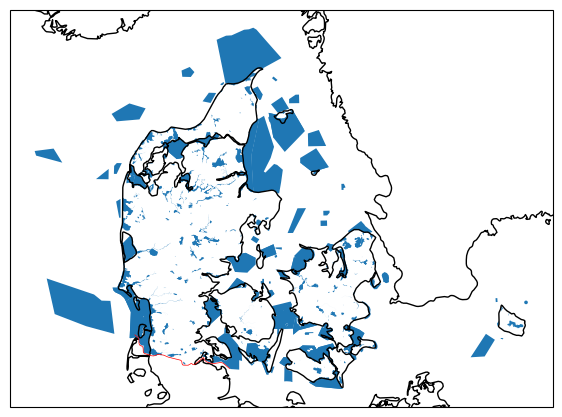

In [4]:
fig = plt.figure(figsize=(7, 7))

ax = plt.axes(projection=ccrs.epsg(3035))

natura.plot(
    ax=ax
)
ax.coastlines()
ax.add_feature(cartopy.feature.BORDERS, color="red", linewidth=0.5)

**Task 3:** Identify the name of the largest protected area in the `natura` GeoDataFrame.

In [5]:
natura["area_m2"] = natura.geometry.area/1e6
natura.sort_values("area_m2", ascending=False).head(1)

,SITECODE,SITENAME,MS,SITETYPE,INSPIRE_ID,geometry,area_m2
309,DK00FX112,Skagens Gren og Skagerak,DK,B,Dk.nst.ps.SAC1,"POLYGON ((4323183.452 3832152.576, 4323366.574...",2704.703911


**Task 4:** What is the total protection area in square kilometers.

In [6]:
natura.dissolve().geometry.area/1e6

0    22646.375701
dtype: float64

**Task 5:** The `natura` GeoDataFrame has a column `SITETYPE` that indicates the type of protected area. Calculate the total area for each type of protected area (again in square kilometers).

In [7]:
natura[["SITETYPE","geometry"]].dissolve(by="SITETYPE").geometry.area/1e6

SITETYPE
A    11751.536465
B    16632.563873
C     3037.541735
dtype: float64

**Task 6:** By how much (in percent) would the total area of protected areas increase if a buffer of 1 km around each protected area were also protected?

In [17]:
natura_site_geo = natura[["SITETYPE","geometry"]]

In [25]:
natura_site_geo.loc[:, '1km_buffer']  = natura_site_geo.geometry.buffer(1000)

In [31]:
ori_area = natura[["SITETYPE","geometry"]].dissolve(by="SITETYPE").geometry.area/1e6


In [38]:
natura_buffer = natura_site_geo.set_geometry("1km_buffer")
inc_area = natura_buffer[["SITETYPE","1km_buffer"]].dissolve(by="SITETYPE")['1km_buffer'].area/1e6

In [41]:
(ori_area/inc_area)*100

SITETYPE
A    72.842000
B    63.498728
C    77.534422
dtype: float64

In [46]:
((natura_buffer.dissolve().area/1e6)/(natura.dissolve().area/1e6))*100 - 100

0    46.434737
dtype: float64

**Task 7:** List the power plants that are located within protected areas. How many power plants are located within protected areas? Use the [`.sjoin()`](https://geopandas.org/en/stable/docs/reference/api/geopandas.sjoin.html) function. Check the result by plotting these power plants on top of the protected areas.

In [48]:
natura = natura.drop(columns = ['area_m2'])

In [51]:
natura.crs

<Projected CRS: EPSG:3035>
Name: ETRS89-extended / LAEA Europe
Axis Info [cartesian]:
- Y[north]: Northing (metre)
- X[east]: Easting (metre)
Area of Use:
- name: Europe - European Union (EU) countries and candidates. Europe - onshore and offshore: Albania; Andorra; Austria; Belgium; Bosnia and Herzegovina; Bulgaria; Croatia; Cyprus; Czechia; Denmark; Estonia; Faroe Islands; Finland; France; Germany; Gibraltar; Greece; Hungary; Iceland; Ireland; Italy; Kosovo; Latvia; Liechtenstein; Lithuania; Luxembourg; Malta; Monaco; Montenegro; Netherlands; North Macedonia; Norway including Svalbard and Jan Mayen; Poland; Portugal including Madeira and Azores; Romania; San Marino; Serbia; Slovakia; Slovenia; Spain including Canary Islands; Sweden; Switzerland; Türkiye (Turkey); United Kingdom (UK) including Channel Islands and Isle of Man; Vatican City State.
- bounds: (-35.58, 24.6, 44.83, 84.73)
Coordinate Operation:
- name: Europe Equal Area 2001
- method: Lambert Azimuthal Equal Area
Datum: Eur

In [53]:
ppl = ppl.to_crs(epsg=3035)

In [64]:
ppl_in_natura = gpd.clip(ppl, natura)

(3495804.7175999996, 3894332.8576)

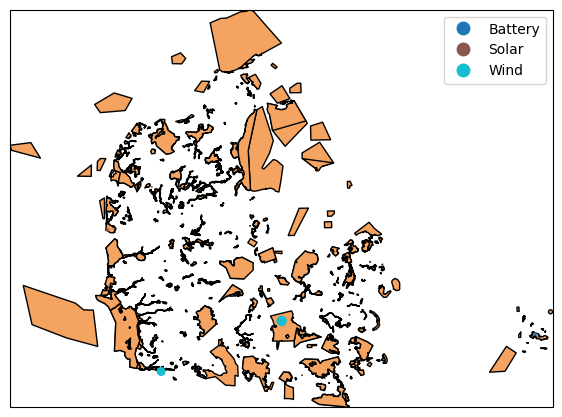

In [69]:
fig = plt.figure(figsize=(7, 7))

ax = plt.axes(projection=ccrs.epsg(3035))

natura.plot(ax=ax, edgecolor="black", facecolor="sandybrown")

ppl_in_natura.to_crs(3035).plot(
    ax=ax, column="Fueltype", markersize=ppl_in_natura.Capacity/0.5, legend=True
)

ax.set_extent([-7, 24, 40, 62])

minx, miny, maxx, maxy = natura.total_bounds
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)

In [70]:
ppl_in_natura = gpd.sjoin(
    ppl,
    natura[["SITETYPE", "geometry"]],
    predicate="within"
)

In [73]:
len(ppl_in_natura)

4

In [74]:
ppl_in_natura

,Name,Fueltype,Technology,Set,Country,Capacity,Efficiency,DateIn,DateRetrofit,DateOut,...,lon,Duration,Volume_Mm3,DamHeight_m,StorageCapacity_MWh,EIC,projectID,geometry,index_right,SITETYPE
id,,,,,,,,,,,,,,,,,,,,,
6144,Sprogo Offshore Wind Farm,Wind,Offshore,PP,Denmark,21.0,NaN,2009.0,NaN,NaN,...,10.9396,NaN,NaN,NaN,NaN,{nan},"{'GEM': {'G100000914988'}, 'GPD': {'WRI1030002'}}",POINT (4380645.027 3582173.5),201,B
16450,Rens Hedegard Plantage Wind Farm,Wind,Onshore,PP,Denmark,15.0,NaN,2010.0,NaN,NaN,...,9.0467,NaN,NaN,NaN,NaN,{nan},{'GEM': {'G100000913204'}},POINT (4259799.359 3531446.118),90,A
16509,Ringkobing Skjern Solar,Solar,PV,PP,Denmark,1.0,NaN,2013.0,NaN,NaN,...,8.1540,NaN,NaN,NaN,NaN,{nan},{'GEM': {'G100001008126'}},POINT (4206196.591 3673153.835),109,C
18958,Boss,Battery,Li,Store,Denmark,1.0,NaN,NaN,NaN,NaN,...,14.9200,NaN,NaN,NaN,1.0,{nan},{'EESI': {'EESI-64169'}},POINT (4634684.769 3569011.488),11,C


**Task 8 (advanced):** What fraction of the natural protection area is located offshore? Use set operations with the [`.overlay()`](https://geopandas.org/en/stable/docs/user_guide/set_operations.html#set-operations-with-overlay) function and the NUTS regions `GeoDataFrame`.

:::{note}
Consult the [GeoPandas documentation](https://geopandas.org/en/stable/docs/user_guide/index.html) if you need an introduction to how to use the `.overlay()` function.
:::